# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="/Users/tomlin/Documents/Github-Repository/RLND/RLND-project/p3_collab-compet/Tennis.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!


Note that **in this coding environment, you should set `train_mode=True` to restart the environment.**

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 4.1 Define `Training` Function

In [5]:
import torch
from collections import deque

def train_mad4pg(agent, n_agents, n_episodes, check_pth='./checkpoint.pth'):
    epi_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(n_agents)
        while True:
            actions = agent.acts(states, mode ='train') # (n_agents, action_size)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards # (n_agents,)
            dones = env_info.local_done # (n_agents,)
            
            agent.step(states, actions, rewards, next_states, dones)
            
            scores += env_info.rewards # (n_agents,)
            states = next_states # (n_agents, state_size)
            if np.any(dones):
                break
        scores_window.append(np.max(scores))
        epi_scores.append(np.max(scores))
        print('\rEpisode {:>4}\tAverage Score:{:>6.3f}\tMemory Size:{:>5}'.format(
            i_episode, np.mean(scores_window), len(agent.memory)), end="")
        if i_episode % 1000 == 0:
            print('\rEpisode {:>4}\tAverage Score:{:>6.3f}\tMemory Size:{:>5}'.format(
                i_episode, np.mean(scores_window), len(agent.memory)))
        if np.mean(scores_window) > 0.6:
            break
    checkpoint = {
        'actor0':agent.mad4pg_agent[0].actor_local.state_dict(),
        'actor1':agent.mad4pg_agent[1].actor_local.state_dict(),
        'critic0':agent.mad4pg_agent[0].critic_local.state_dict(),
        'critic1':agent.mad4pg_agent[1].critic_local.state_dict()
    }
    torch.save(checkpoint, check_pth)
    return epi_scores

In [6]:
from workspace_utils import active_session
from mad4pg_agent import MAD4PG

agent = MAD4PG(state_size=24, action_size=2, seed=199)
with active_session():
    epi_scores = train_mad4pg(agent, n_agents=2, n_episodes=10000)
    epi_scores = np.array(epi_scores)
    np.save('./epi_scores.npy', epi_scores)

Episode 1000	Average Score: 0.007	Memory Size:16260
Episode 2000	Average Score: 0.006	Memory Size:31459
Episode 3000	Average Score: 0.045	Memory Size:51323
Episode 4000	Average Score: 0.058	Memory Size:76597
Episode 5000	Average Score: 0.067	Memory Size:100000
Episode 6000	Average Score: 0.072	Memory Size:100000
Episode 7000	Average Score: 0.147	Memory Size:100000
Episode 7468	Average Score: 0.602	Memory Size:100000

#### 4.2 Plot The Scores

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

def plot_scores(scores, rolling_window=100):
    '''Plot score and its moving average on the same chart.'''
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(scores)), scores, '-c', label='episode score')
    plt.title('Episodic Score')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(np.arange(len(scores)), rolling_mean, '-y', label='rolling_mean')
    plt.ylabel('score')
    plt.xlabel('episode #')
    plt.legend()

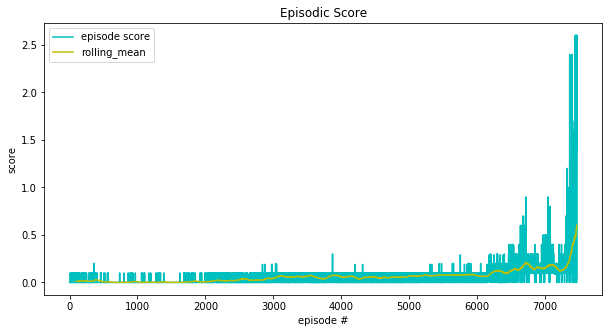

In [8]:
epi_scores = np.load('./epi_scores.npy')
plot_scores(epi_scores)

#### 4.3 Test The Performance of Agents After Training

In [6]:
import torch
from mad4pg_agent import MAD4PG
agent = MAD4PG(state_size=24, action_size=2, seed=199)

checkpoint = torch.load('./checkpoint.pth', map_location=lambda storage, loc:storage)
actor0_state_dict = checkpoint['actor0']
actor1_state_dict = checkpoint['actor1']
critic0_state_dict = checkpoint['critic0']
critic1_state_dict = checkpoint['critic1']

agent.mad4pg_agent[0].actor_local.load_state_dict(actor0_state_dict)
agent.mad4pg_agent[1].actor_local.load_state_dict(actor1_state_dict)
agent.mad4pg_agent[0].critic_local.load_state_dict(critic0_state_dict)
agent.mad4pg_agent[1].critic_local.load_state_dict(critic1_state_dict)

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.acts(states, mode ='test')
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.650000039488077
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.550000037997961


### 5. Model Selection

The final chosen model is **Distributed Distributional Deterministic Policy Gradients (D4PG)**. For two agents in this case, I set up two instances of D4PG network, one for each agent.

Compared with the Multi-Agent Deep Deterministic Policy Gradient (MADDPG), I found that D4PG is more efficient in training the agents. In MADDPG, we need to take the states and actions of other agents' into account - specifically on critic netork. But in my multi-agent D4PG, each agent only observes its own state and acts based on the state. It is just like usual D4PG algorithm, except that this time it is implemented on multiple agents.

### 6. Model Structure and Hyperparameter

1. Both actor and critic network of D4PG are composed of **two hidden layers (all with size of 64 units)**. The **leaky relu** is used in the model (instead of regular relu activation function). For actor, the output of output layer is **batch normalized** before being fed to tahn() activation function and the **final range of action value is clipped within (-1,1)**.

2. The **exploration policy** for action is set with **epsilon 0.3 times random noise** from normal distribution.

3. The networks are **updated for every 10 steps** and **soft update** is used with **TAU 0.001**.

4. Replay memory is randomly sampled with batch size 64.


> The full specifications of hyperparameters:
- Learning rate for actor: 1e-4
- Learning rate for critic: 1e-3
- reward discount factor gamma: 0.99
- size of replay memory: 1e5
- batch size for learning: 64
- TAU for soft update: 1e-3
- Learning every step: 10
- N_ATOMS (D4PG): 51
- Vmax (D4PG): 1
- Vmin (D4PG): -1

### 7. Learning Progression

The model learns quite slow in the first 5000 episodes and begins to kick off very quickly after 7000th episode. It successfully solves the task within 8000 episodes. 

### 8. Further Ideas

In this task, I only use D4PG with one step state-action pairs. It may perform much better with N-steps trajectories. The prioritized memory replay can help increase learning efficiency as well. 